# Confidence Intervals

To this point, this guide has focused on the functions and syntax necessary to manipulate, explore and describe data. Data cleaning and exploratory analysis are often preliminary steps toward the end goal of extracting insight from data through statistical inference or predictive modeling. The remainder of this guide will focus on methods for analyzing data and tools for carrying out analyses in Python.

Statistical inference is the process of analyzing sample data to gain insight into the population from which the data was collected and to investigate differences between data samples. In data analysis, we are often interested in the characteristics of some large population, but collecting data on the entire population may be infeasible. For example, leading up to U.S. presidential elections it could be very useful to know the political leanings of every single eligible voter, but surveying every voter is not feasible. Instead, we could poll some subset of the population, such as a thousand registered voters, and use that data to make inferences about the population as a whole.

## Point Estimates

Point estimates are estimates of population parameters based on sample data. For instance, if we wanted to know the average age of registered voters in the U.S., we could take a survey of registered voters and then use the average age of the respondents as a point estimate of the average age of the population as a whole. The average of a sample is known as the sample mean.

The sample mean is usually not exactly the same as the population mean. This difference can be caused by many factors including poor survey design, biased sampling methods and the randomness inherent to drawing a sample from a population. Let's investigate point estimates by generating a population of random age data and then drawing a sample from it to estimate the mean:

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import math

In [19]:
np.random.seed(10)
population_ages1 = stats.poisson.rvs(loc=18, mu=35, size=150000)
population_ages2 = stats.poisson.rvs(loc=18, mu=10, size=100000)
population_ages = np.concatenate((population_ages1, population_ages2))

population_ages.mean()

43.002372

In [20]:
np.random.seed(6)
sample_ages = np.random.choice(a= population_ages,
                               size=500)            # Sample 1000 values

print ( sample_ages.mean() )                         # Show sample mean

population_ages.mean() - sample_ages.mean()   # Check difference between means

42.388


0.614372000000003

Our point estimate based on a sample of 500 individuals underestimates the true population mean by 0.6 years, but it is close. This illustrates an important point: we can get a fairly accurate estimate of a large population by sampling a relatively small subset of individuals.

Another point estimate that may be of interest is the proportion of the population that belongs to some category or subgroup. For example, we might like to know the race of each voter we poll, to get a sense of the overall demographics of the voter base. You can make a point estimate of this sort of proportion by taking a sample and then checking the ratio in the sample:

In [21]:
random.seed(10)
population_races = (["white"]*100000) + (["black"]*50000) +\
                   (["hispanic"]*50000) + (["asian"]*25000) +\
                   (["other"]*25000)
    
demo_sample = random.sample(population_races, 1000)   # Sample 1000 values

for race in set(demo_sample):
    print( race + " proportion estimate:" )
    print( demo_sample.count(race)/1000 )

hispanic proportion estimate:
0.192
black proportion estimate:
0.231
white proportion estimate:
0.379
asian proportion estimate:
0.099
other proportion estimate:
0.099


Notice that the proportion estimates are close to the true underlying population proportions.

## Sampling Distributions and The Central Limit Theorem

Many statistical procedures assume that data follows a normal distribution, because the normal distribution has nice properties like symmetricity and having the majority of the data clustered within a few standard deviations of the mean. Unfortunately, real world data is often not normally distributed and the distribution of a sample tends to mirror the distribution of the population. This means a sample taken from a population with a skewed distribution will also tend to be skewed. Let's investigate by plotting the data and sample we created earlier and by checking the skew:

-0.12008483603917186


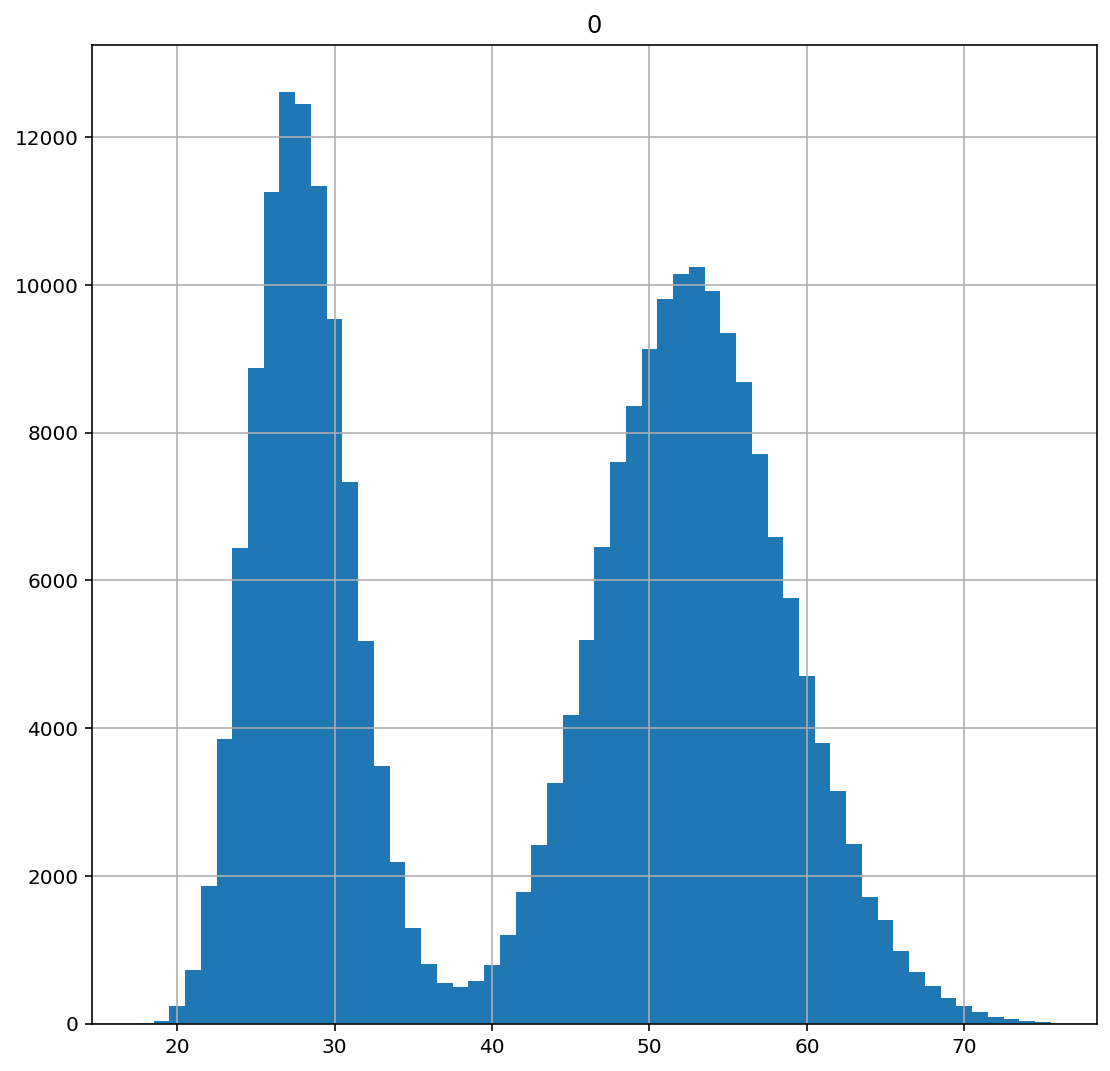

In [22]:
pd.DataFrame(population_ages).hist(bins=58,
                                  range=(17.5,75.5),
                                  figsize=(9,9))

print( stats.skew(population_ages) );

The distribution has low skewness, but the plot reveals the data is clearly not normal: instead of one symmetric bell curve, it has as bimodal distribution with two high density peaks. The sample we drew from this population should have roughly the same shape and skew:

-0.056225282585406065


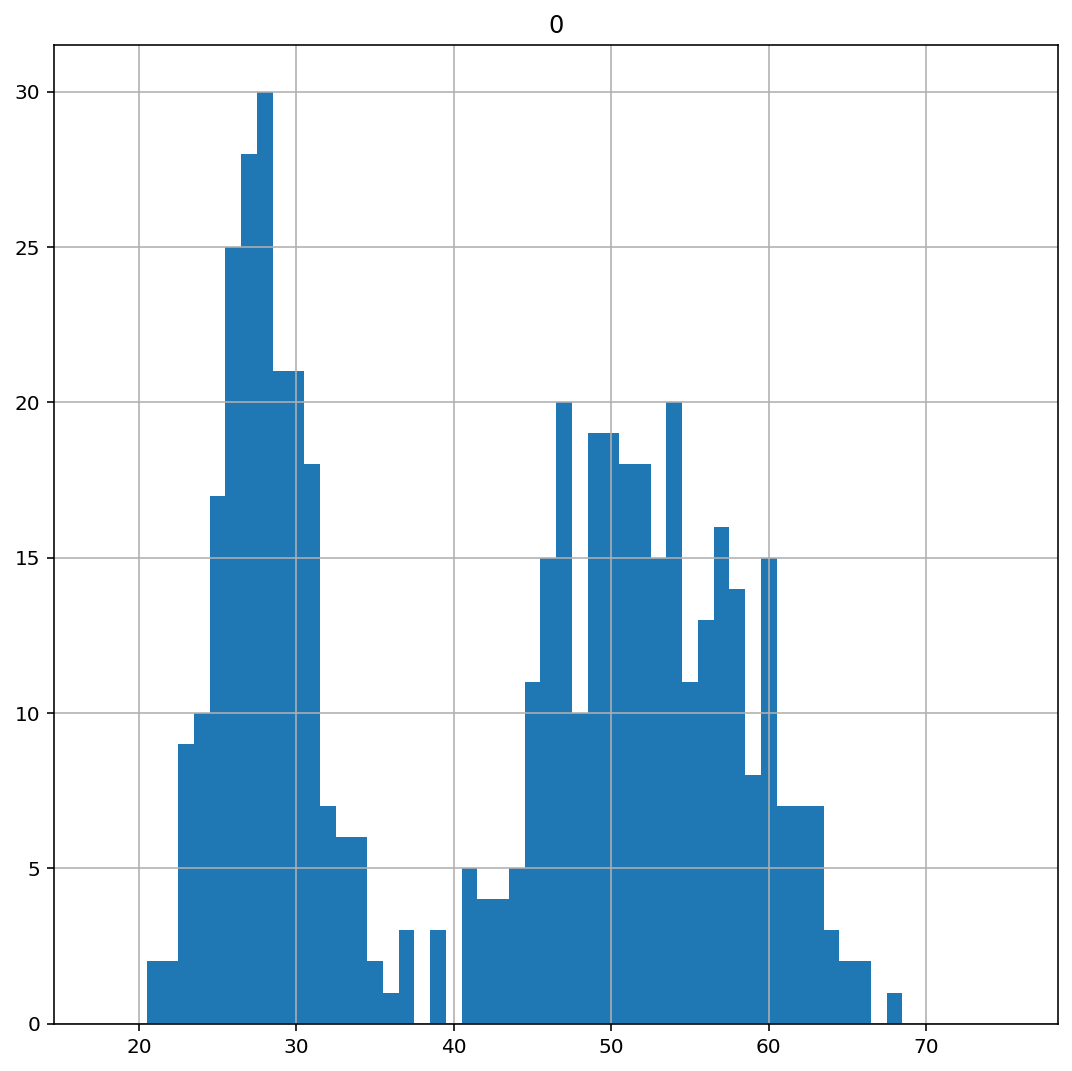

In [23]:
pd.DataFrame(sample_ages).hist(bins=58,
                                  range=(17.5,75.5),
                                  figsize=(9,9));

print( stats.skew(sample_ages) )

The sample has roughly the same shape as the underlying population. This suggests that we can't apply techniques that assume a normal distribution to this data set, since it is not normal. In reality, we can, thanks the central limit theorem.

The central limit theorem is one of the most important results of probability theory and serves as the foundation of many methods of statistical analysis. At a high level, the theorem states the distribution of many sample means, known as a sampling distribution, will be normally distributed. This rule holds even if the underlying distribution itself is not normally distributed. As a result we can treat the sample mean as if it were drawn normal distribution.

To illustrate, let's create a sampling distribution by taking 200 samples from our population and then making 200 point estimates of the mean:

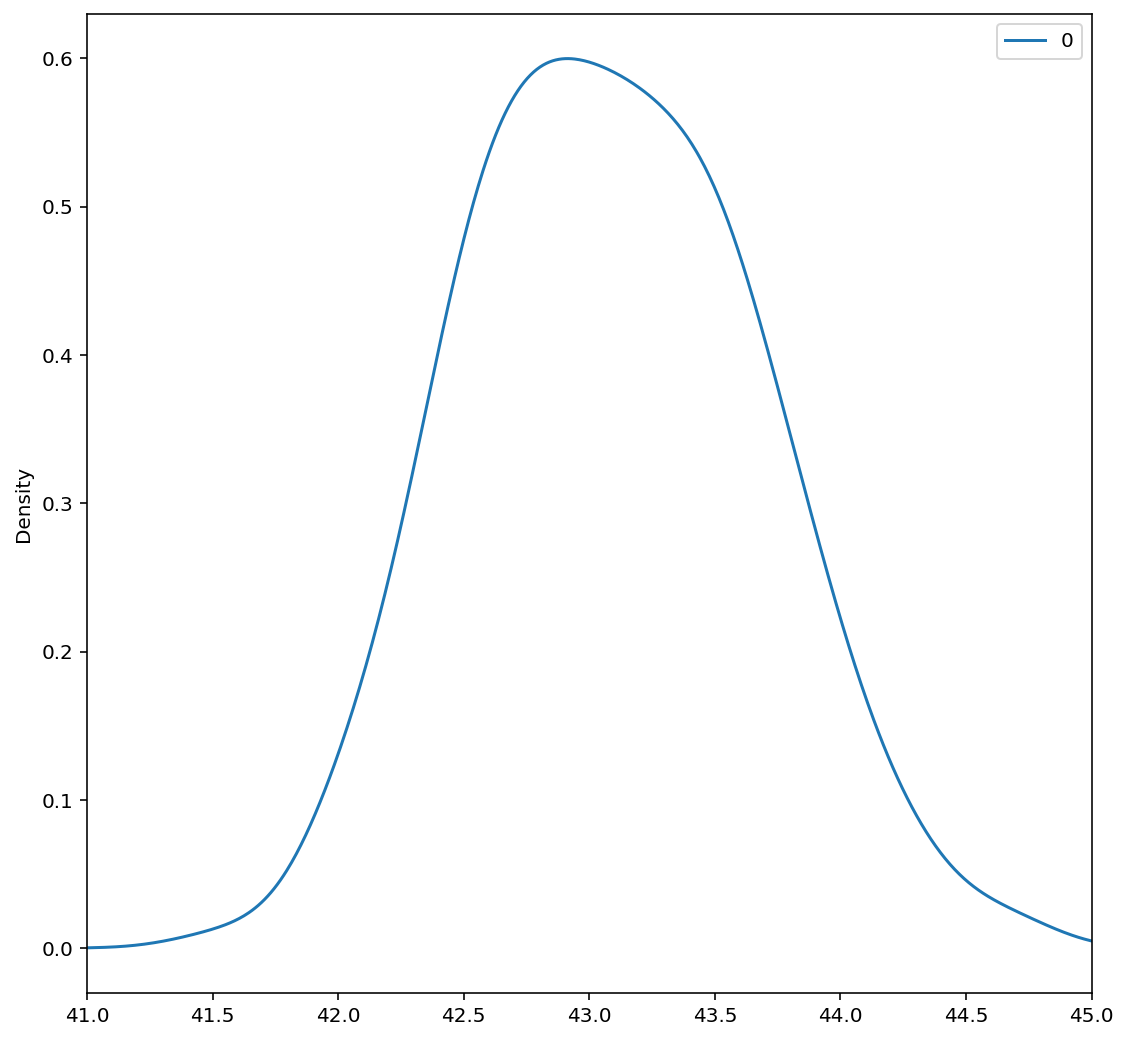

In [24]:

np.random.seed(10)

point_estimates = []         # Make empty list to hold point estimates

for x in range(200):         # Generate 200 samples
    sample = np.random.choice(a= population_ages, size=500)
    point_estimates.append( sample.mean() )
    
pd.DataFrame(point_estimates).plot(kind="density",  # Plot sample mean density
                                   figsize=(9,9),
                                   xlim=(41,45));  

The sampling distribution appears to be roughly normal, despite the bimodal population distribution that the samples were drawn from. In addition, the mean of the sampling distribution approaches the true population mean:

In [25]:
population_ages.mean() - np.array(point_estimates).mean()

-0.08440799999999626

The more samples we take, the better our estimate of the population parameter is likely to be.

## Confidence Intervals

A point estimate can give you a rough idea of a population parameter like the mean, but estimates are prone to error and taking multiple samples to get improved estimates may not be feasible. A confidence interval is a range of values above and below a point estimate that captures the true population parameter at some predetermined confidence level. For example, if you want to have a 95% chance of capturing the true population parameter with a point estimate and a corresponding confidence interval, you'd set your confidence level to 95%. Higher confidence levels result in a wider confidence intervals.

Calculate a confidence interval by taking a point estimate and then adding and subtracting a margin of error to create a range. Margin of error is based on your desired confidence level, the spread of the data and the size of your sample. The way you calculate the margin of error depends on whether you know the standard deviation of the population or not.

If you know the standard deviation of the population, the margin of error is equal to:

$$z * \frac{\sigma}{\sqrt{n}}$$

Where σ (sigma) is the population standard deviation, n is sample size, and z is a number known as the z-critical value. The z-critical value is the number of standard deviations you'd have to go from the mean of the normal distribution to capture the proportion of the data associated with the desired confidence level. For instance, we know that roughly 95% of the data in a normal distribution lies within 2 standard deviations of the mean, so we could use 2 as the z-critical value for a 95% confidence interval (although it is more exact to get z-critical values with stats.norm.ppf().).

Let's calculate a 95% confidence for our mean point estimate:

In [26]:
np.random.seed(10)

sample_size = 1000
sample = np.random.choice(a= population_ages, size = sample_size)
sample_mean = sample.mean()

z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*

print("z-critical value:")              # Check the z-critical value
print(z_critical)                        

pop_stdev = population_ages.std()  # Get the population standard deviation

margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:")
print(confidence_interval)

z-critical value:
1.959963984540054
Confidence interval:
(41.70306406882683, 43.34293593117317)


*Note: We use stats.norm.ppf(q = 0.975) to get the desired z-critical value instead of q = 0.95 because the distribution has two tails.*

Notice that the confidence interval we calculated captures the true population mean of 43.0023.

Let's create several confidence intervals and plot them to get a better sense of what it means to "capture" the true mean:

In [27]:
np.random.seed(12)

sample_size = 1000

intervals = []
sample_means = []

for sample in range(25):
    sample = np.random.choice(a= population_ages, size = sample_size)
    sample_mean = sample.mean()
    sample_means.append(sample_mean)

    z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*         

    pop_stdev = population_ages.std()  # Get the population standard deviation

    stats.norm.ppf(q = 0.025)

    margin_of_error = z_critical * (pop_stdev/math.sqrt(sample_size))

    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)  
    
    intervals.append(confidence_interval)

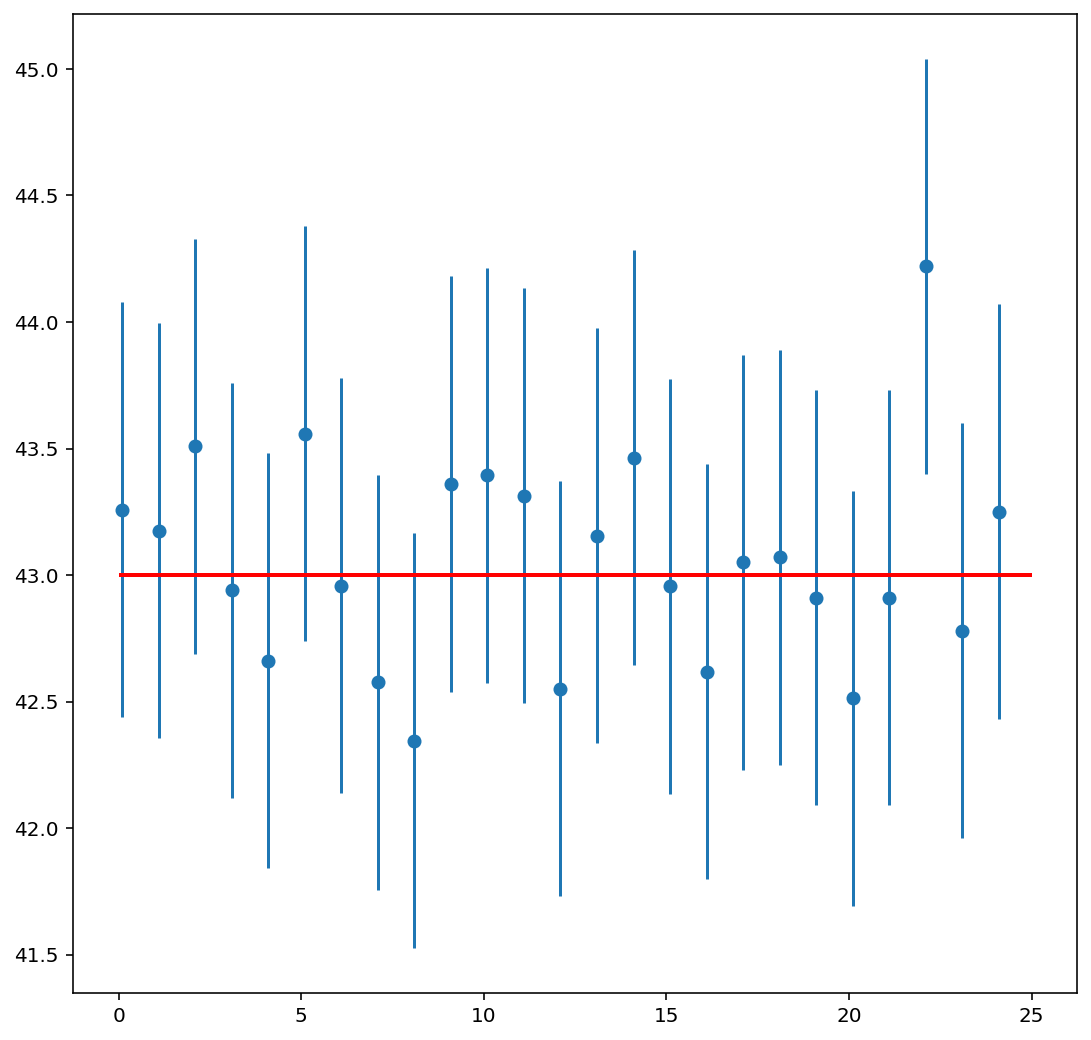

In [28]:
plt.figure(figsize=(9,9))

plt.errorbar(x=np.arange(0.1, 25, 1), 
             y=sample_means, 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='o')

plt.hlines(xmin=0, xmax=25,
           y=43.0023, 
           linewidth=2.0,
           color="red");

Notice that in the plot above, all but one of the 95% confidence intervals overlap the red line marking the true mean. This is to be expected: since a 95% confidence interval captures the true mean 95% of the time, we'd expect our interval to miss the true mean 5% of the time.

If you don't know the standard deviation of the population, you have to use the standard deviation of your sample as a stand in when creating confidence intervals. Since the sample standard deviation may not match the population parameter the interval will have more error when you don't know the population standard deviation. To account for this error, we use what's known as a t-critical value instead of the z-critical value. The t-critical value is drawn from what's known as a t-distribution--a distribution that closely resembles the normal distribution but that gets wider and wider as the sample size falls. The t-distribution is available in scipy.stats with the nickname "t" so we can get t-critical values with stats.t.ppf().

Let's take a new, smaller sample and then create a confidence interval without the population standard deviation, using the t-distribution:

In [29]:
np.random.seed(10)

sample_size = 25
sample = np.random.choice(a= population_ages, size = sample_size)
sample_mean = sample.mean()

t_critical = stats.t.ppf(q = 0.975, df=24)  # Get the t-critical value*

print("t-critical value:")                  # Check the t-critical value
print(t_critical)                        

sample_stdev = sample.std(ddof=1)    # Get the sample standard deviation

sigma = sample_stdev/math.sqrt(sample_size)  # Standard deviation estimate
margin_of_error = t_critical * sigma

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:")
print(confidence_interval)

t-critical value:
2.0638985616280205
Confidence interval:
(37.65147508161371, 48.108524918386294)


*Note: when using the t-distribution, you have to supply the degrees of freedom (df). For this type of test, the degrees of freedom is equal to the sample size minus 1. If you have a large sample size, the t-distribution approaches the normal distribution.*

Notice that the t-critical value is larger than the z-critical value we used for 95% confidence interval. This allows the confidence interval to cast a larger net to make up for the variability caused by using the sample standard deviation in place of the population standard deviation. The end result is a much wider confidence interval (an interval with a larger margin of error.).

If you have a large sample, the t-critical value will approach the z-critical value so there is little difference between using the normal distribution vs. the t-distribution:

In [30]:
# Check the difference between critical values with a sample size of 1000
             
stats.t.ppf(q=0.975, df= 999) - stats.norm.ppf(0.975)  

0.0023774765933946007

Instead of calculating a confidence interval for a mean point estimate by hand, you can calculate it using the Python function stats.t.interval():

In [31]:
stats.t.interval(alpha = 0.95,              # Confidence level
                 df= 24,                    # Degrees of freedom
                 loc = sample_mean,         # Sample mean
                 scale = sigma)             # Standard deviation estimate

(37.65147508161371, 48.108524918386294)

We can also make a confidence interval for a point estimate of a population proportion. In this case, the margin of error equals:

$$z * \sqrt{\frac{p(1-p)}{n}}$$

Where z is the z-critical value for our confidence level, p is the point estimate of the population proportion and n is the sample size. Let's calculate a 95% confidence interval for Hispanics according to the sample proportion we calculated earlier (0.192):

In [32]:
z_critical = stats.norm.ppf(0.975)      # Record z-critical value

p = 0.192                               # Point estimate of proportion

n = 1000                                # Sample size

margin_of_error = z_critical * math.sqrt((p*(1-p))/n)

confidence_interval = (p - margin_of_error,  # Calculate the the interval
                       p + margin_of_error) 

confidence_interval

(0.16758794241348748, 0.21641205758651252)

The output shows that the confidence interval captured the true population parameter of 0.2. Similar to our population mean point estimates, we can use the scipy stats.distribution.interval() function to calculate a confidence interval for a population proportion for us. In this case were working with z-critical values so we want to work with the normal distribution instead of the t distribution:

In [33]:
stats.norm.interval(alpha = 0.95,    # Confidence level             
                   loc =  0.192,     # Point estimate of proportion
                   scale = math.sqrt((p*(1-p))/n))  # Scaling factor

(0.16758794241348748, 0.21641205758651252)

## Wrap Up

Estimating population parameters through sampling is a simple, yet powerful form of inference. Point estimates combined with error margins let us create confidence intervals that capture the true population parameter with high probability.